# CAPTCHA Recognition Pipeline with Segmentation

This notebook integrates the character segmentation approach from `segmentation.py` with a CNN-based character recognition model.

## 1. Environment Setup

In [70]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Character set
CHARS = "0123456789abcdefghijklmnopqrstuvwxyz"
VOCAB_SIZE = len(CHARS)
ch2id = {ch: i for i, ch in enumerate(CHARS)}
id2ch = {i: ch for ch, i in ch2id.items()}

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Characters: {CHARS}")

device: cuda
Vocabulary size: 36
Characters: 0123456789abcdefghijklmnopqrstuvwxyz


## 2. Import Segmentation Functions

Import the segmentation functions directly from `segmentation.py`.

In [71]:
# Import segmentation functions from segmentation.py
from segmentation import get_dominant_clusters

def segment_characters(image_path, min_pixels=3, top_components=5):
    """
    Segment CAPTCHA characters using adaptive KMeans thresholding.
    Returns a list of character images and their labels.
    This uses the same logic as segment_and_save_characters from segmentation.py
    but returns the data instead of saving to files.
    """
    filename = Path(image_path).stem
    chars_part = filename.split("-")[0]
    n_clusters = len(chars_part) + 1  # +1 for noise cluster

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")

    threshold = 250
    max_threshold = 250
    step = 10
    valid_bounding_boxes = []

    # Try increasing threshold until enough clusters found
    while threshold <= max_threshold:
        clustered_masks, mask_foreground = get_dominant_clusters(image, n_clusters, threshold)
        if clustered_masks is None:
            threshold += step
            continue

        bounding_boxes = []
        for idx, mask in enumerate(clustered_masks):
            ys, xs = np.where(mask > 0)
            if len(xs) == 0:
                continue
            x_min, x_max = np.min(xs), np.max(xs)
            y_min, y_max = np.min(ys), np.max(ys)
            w, h = x_max - x_min + 1, y_max - y_min + 1
            bounding_boxes.append((x_min, y_min, w, h, mask))

        if len(bounding_boxes) >= n_clusters:
            valid_bounding_boxes = bounding_boxes
            break
        threshold += step

    if not valid_bounding_boxes:
        print(f"[WARNING] Failed to segment {image_path}")
        return [], []

    cluster_pixel_counts = []
    cleaned_clusters = []
    cluster_x_positions = []  # store leftmost pixel x position of largest component

    # Clean clusters (keep top N largest connected parts, filter by distance)
    for i, (x, y, w, h, mask) in enumerate(valid_bounding_boxes):
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

        if num_labels > 1:
            areas = stats[1:, cv2.CC_STAT_AREA]
            sorted_idx = np.argsort(areas)[::-1]  # largest → smallest

            keep_mask = np.zeros_like(mask)
            count_kept = 0
            first_center = None
            distance_threshold = 25  # tune for your CAPTCHA size

            for idx2 in sorted_idx:
                if count_kept >= top_components:
                    break
                area = areas[idx2]
                if area < min_pixels:
                    continue

                label = idx2 + 1
                cx, cy = centroids[label]

                if first_center is None:
                    # Always keep the first (largest) component
                    first_center = (cx, cy)
                    keep_mask[labels == label] = 255
                    count_kept += 1
                else:
                    # Compute Euclidean distance to the first component
                    dist = np.sqrt((cx - first_center[0]) ** 2 + (cy - first_center[1]) ** 2)
                    if dist < distance_threshold:
                        keep_mask[labels == label] = 255
                        count_kept += 1

            cleaned_mask = keep_mask
        else:
            cleaned_mask = mask.copy()

        # record x position of largest connected component
        ys, xs = np.where(cleaned_mask > 0)
        if len(xs) > 0:
            x_leftmost = np.min(xs)
        else:
            x_leftmost = 99999  # fallback in case mask empty

        pixel_count = np.sum(cleaned_mask > 0)
        cluster_pixel_counts.append(pixel_count)
        cleaned_clusters.append((x, y, w, h, cleaned_mask))
        cluster_x_positions.append(x_leftmost)

    # Identify cluster with fewest pixels (noise)
    min_idx = int(np.argmin(cluster_pixel_counts))

    # Sort by leftmost pixel (x position of biggest component)
    sorted_indices = np.argsort(cluster_x_positions)

    # Extract character images (excluding the noise cluster)
    char_images = []
    char_labels = []
    
    for order, i in enumerate(sorted_indices):
        if i == min_idx:  # Skip noise cluster
            continue
            
        x, y, w, h, cleaned_mask = cleaned_clusters[i]
        roi = image[y:y + h, x:x + w]
        mask_roi = cleaned_mask[y:y + h, x:x + w]
        char_img = np.full_like(roi, 255)  # White background
        char_img[mask_roi == 255] = roi[mask_roi == 255]
        
        # Crop tightly to foreground
        gray = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        ys_fg, xs_fg = np.where(gray < 250)  # find non-white pixels
        if len(xs_fg) > 0 and len(ys_fg) > 0:
            x_min_fg, x_max_fg = np.min(xs_fg), np.max(xs_fg)
            y_min_fg, y_max_fg = np.min(ys_fg), np.max(ys_fg)
            char_img = char_img[y_min_fg:y_max_fg + 1, x_min_fg:x_max_fg + 1]
        
        char_images.append(char_img)
        
        # Determine label based on sorted order
        # Account for deleted cluster
        char_idx = order
        if i > min_idx:
            char_idx = order
        elif i < min_idx:
            char_idx = order
        else:
            continue  # This is the deleted cluster, already skipped
            
        if char_idx < len(chars_part):
            char_labels.append(chars_part[char_idx])
        else:
            char_labels.append('')  # Should not happen
    
    return char_images, char_labels

## 3. Character Dataset

Dataset class that segments CAPTCHAs and provides individual character images for training.

In [72]:
class SegmentedCharDataset(Dataset):
    def __init__(self, img_paths, transform=None, target_size=(32, 32)):
        """
        Args:
            img_paths: List of CAPTCHA image paths
            transform: Optional transform to be applied on characters
            target_size: Target size for character images (H, W)
        """
        self.img_paths = img_paths
        self.transform = transform
        self.target_size = target_size
        
        # Pre-segment all images and build character dataset
        self.characters = []  # List of (char_image, label)
        self._build_dataset()
    
    def _build_dataset(self):
        print("Segmenting CAPTCHA images...")
        for img_path in tqdm(self.img_paths):
            try:
                char_images, char_labels = segment_characters(img_path)
                for char_img, label in zip(char_images, char_labels):
                    if label and label in ch2id:  # Valid label
                        self.characters.append((char_img, label))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        print(f"Total characters extracted: {len(self.characters)}")
    
    def __len__(self):
        return len(self.characters)
    
    def __getitem__(self, idx):
        char_img, label = self.characters[idx]
        
        # Preprocess character image
        char_img = self._preprocess_char(char_img)
        
        # Convert to tensor
        char_img = torch.from_numpy(char_img).float() / 255.0
        
        if self.transform:
            char_img = self.transform(char_img)
        
        # Ensure 3 channels
        if char_img.dim() == 2:
            char_img = char_img.unsqueeze(0).repeat(3, 1, 1)
        elif char_img.shape[0] == 1:
            char_img = char_img.repeat(3, 1, 1)
        
        label_id = ch2id[label]
        
        return char_img, label_id, label
    
    def _preprocess_char(self, char_img):
        """
        Preprocess a single character image:
        - Convert to grayscale
        - Resize to target size
        - Maintain aspect ratio with padding
        """
        # Convert to grayscale if needed
        if len(char_img.shape) == 3:
            char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        
        h, w = char_img.shape
        target_h, target_w = self.target_size
        
        # Check for invalid dimensions
        if h <= 0 or w <= 0:
            # Return blank canvas if image is empty
            return np.ones((target_h, target_w), dtype=np.uint8) * 255
        
        # Calculate scaling to fit within target size
        scale = min(target_h / h, target_w / w)
        new_h, new_w = int(h * scale), int(w * scale)
        
        # Ensure minimum size of 1x1
        new_h = max(1, new_h)
        new_w = max(1, new_w)
        
        # Resize
        char_img = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        
        # Create white canvas and center the character
        canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
        y_offset = (target_h - new_h) // 2
        x_offset = (target_w - new_w) // 2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
        
        return canvas

## 4. Load and Prepare Data

In [73]:
# Data directories
TRAIN_ROOT = "processed/train"
TEST_ROOT = "processed/test"

# Get image files
train_img_files = [
    os.path.join(TRAIN_ROOT, f)
    for f in os.listdir(TRAIN_ROOT)
    if f.lower().endswith(".png")
]

test_img_files = [
    os.path.join(TEST_ROOT, f)
    for f in os.listdir(TEST_ROOT)
    if f.lower().endswith(".png")
]

print(f"Train CAPTCHA images: {len(train_img_files)}")
print(f"Test CAPTCHA images: {len(test_img_files)}")

Train CAPTCHA images: 8010
Test CAPTCHA images: 2000


In [74]:
# Create datasets
print("\nCreating training dataset...")
train_dataset = SegmentedCharDataset(train_img_files[:100], target_size=(32, 32))  # Limit for testing

print("\nCreating test dataset...")
test_dataset = SegmentedCharDataset(test_img_files[:20], target_size=(32, 32))  # Limit for testing


Creating training dataset...
Segmenting CAPTCHA images...


  0%|          | 0/100 [00:00<?, ?it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
  3%|▎         | 3/100 [00:00<00:04, 22.01it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
  3%|▎         | 3/100 [00:00<00:04, 22.01it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

Total characters extracted: 513

Creating test dataset...
Segmenting CAPTCHA images...


  0%|          | 0/20 [00:00<?, ?it/s]d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\sklearn\cluster\_kmeans.py:

Total characters extracted: 108


## 5. Visualize Segmented Characters

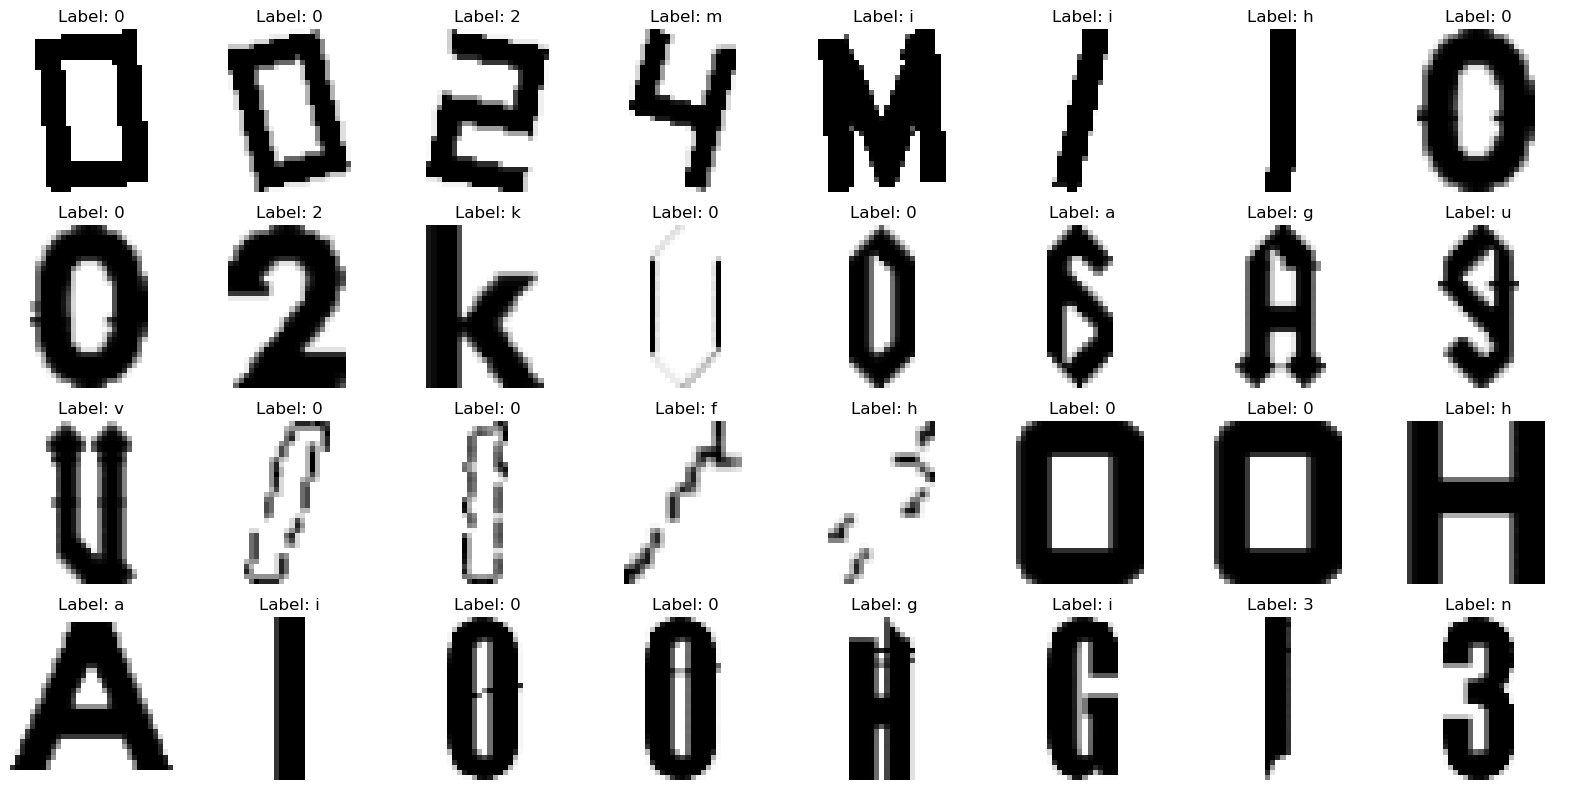

In [75]:
# Visualize some examples
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(32, len(train_dataset))):
    char_img, label_id, label = train_dataset[i]
    
    # Convert tensor to numpy for display
    img_np = char_img[0].numpy()  # Take first channel
    
    axes[i].imshow(img_np, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 6. Character Recognition Model

CNN-based model for recognizing individual characters.

In [76]:
class CharRecognitionCNN(nn.Module):
    def __init__(self, num_classes=VOCAB_SIZE, dropout=0.5):
        super(CharRecognitionCNN, self).__init__()
        
        # Use ResNet18 as backbone
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Remove the final FC layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        
        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Initialize model
model = CharRecognitionCNN(num_classes=VOCAB_SIZE).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

CharRecognitionCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

## 7. Create DataLoaders

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True  # Drop last incomplete batch to avoid BatchNorm issues
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
    # No drop_last for test - we use model.eval() which disables BatchNorm training mode
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 17
Test batches: 4


## 8. Training Setup

In [78]:
# Training hyperparameters
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

d:\D\Miniconda3\envs\cs4243_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 9. Training Loop

In [79]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for imgs, labels, _ in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })
    
    return running_loss / len(loader), 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [80]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

best_acc = 0.0

# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(test_acc)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # Print summary
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_char_recognition_model.pth')
        print(f"✓ New best model saved! Accuracy: {best_acc:.2f}%")

print(f"\nTraining complete! Best accuracy: {best_acc:.2f}%")


Epoch 1/50


Training:  94%|█████████▍| 16/17 [00:00<00:00, 23.54it/s, loss=4.33, acc=13.1]



ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

## 10. Visualize Training History

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. Full CAPTCHA Recognition

Combine segmentation + recognition to decode complete CAPTCHAs.

In [ ]:
def recognize_captcha(model, image_path, device, target_size=(32, 32)):
    """
    Recognize a full CAPTCHA by:
    1. Segmenting characters
    2. Recognizing each character with the CNN model
    3. Combining predictions
    """
    model.eval()
    
    # Segment characters
    char_images, _ = segment_characters(image_path)
    
    if not char_images:
        return "", []
    
    predictions = []
    confidences = []
    
    with torch.no_grad():
        for char_img in char_images:
            # Preprocess
            if len(char_img.shape) == 3:
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
            
            h, w = char_img.shape
            target_h, target_w = target_size
            
            # Check for invalid dimensions
            if h <= 0 or w <= 0:
                continue  # Skip invalid images
            
            scale = min(target_h / h, target_w / w)
            new_h, new_w = int(h * scale), int(w * scale)
            
            # Ensure minimum size of 1x1
            new_h = max(1, new_h)
            new_w = max(1, new_w)
            
            char_img = cv2.resize(char_img, (new_w, new_h))
            
            canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
            y_offset = (target_h - new_h) // 2
            x_offset = (target_w - new_w) // 2
            canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
            
            # Convert to tensor
            char_tensor = torch.from_numpy(canvas).float() / 255.0
            char_tensor = char_tensor.unsqueeze(0).repeat(3, 1, 1)  # 3 channels
            char_tensor = char_tensor.unsqueeze(0).to(device)  # Add batch dimension
            
            # Predict
            output = model(char_tensor)
            probs = F.softmax(output, dim=1)
            confidence, predicted = probs.max(1)
            
            pred_char = id2ch[predicted.item()]
            predictions.append(pred_char)
            confidences.append(confidence.item())
    
    result = ''.join(predictions)
    return result, confidences


def visualize_captcha_prediction(image_path, model, device):
    """
    Visualize CAPTCHA recognition result
    """
    # Get ground truth
    filename = Path(image_path).stem
    gt_text = filename.split('-')[0]
    
    # Predict
    pred_text, confidences = recognize_captcha(model, image_path, device)
    
    # Load and display image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(img_rgb)
    plt.title(f"Ground Truth: {gt_text}\nPrediction: {pred_text}\nConfidence: {np.mean(confidences):.3f}")
    plt.axis('off')
    plt.show()
    
    return gt_text, pred_text

## 12. Test on Sample CAPTCHAs

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_char_recognition_model.pth'))
model.eval()

# Test on a few samples
test_samples = test_img_files[:5]

correct = 0
total = len(test_samples)

for img_path in test_samples:
    gt, pred = visualize_captcha_prediction(img_path, model, device)
    if gt == pred:
        correct += 1
        print(f"✓ Correct!\n")
    else:
        print(f"✗ Wrong. GT: {gt}, Pred: {pred}\n")

print(f"\nAccuracy: {correct}/{total} = {100*correct/total:.2f}%")

## 13. Full Test Set Evaluation

In [ ]:
def evaluate_full_captchas(model, img_paths, device):
    """
    Evaluate on full CAPTCHA images
    """
    model.eval()
    
    total = 0
    correct = 0
    char_total = 0
    char_correct = 0
    
    for img_path in tqdm(img_paths, desc="Evaluating CAPTCHAs"):
        try:
            filename = Path(img_path).stem
            gt_text = filename.split('-')[0].lower()
            
            pred_text, _ = recognize_captcha(model, img_path, device)
            pred_text = pred_text.lower()
            
            total += 1
            if gt_text == pred_text:
                correct += 1
            
            # Character-level accuracy
            for gt_ch, pred_ch in zip(gt_text, pred_text):
                char_total += 1
                if gt_ch == pred_ch:
                    char_correct += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    seq_acc = 100 * correct / total if total > 0 else 0
    char_acc = 100 * char_correct / char_total if char_total > 0 else 0
    
    print(f"\nResults on {total} CAPTCHAs:")
    print(f"Sequence Accuracy: {seq_acc:.2f}% ({correct}/{total})")
    print(f"Character Accuracy: {char_acc:.2f}% ({char_correct}/{char_total})")
    
    return seq_acc, char_acc


# Evaluate on test set
test_seq_acc, test_char_acc = evaluate_full_captchas(model, test_img_files, device)

## 14. Summary and Next Steps

This notebook demonstrates:
1. ✓ Character segmentation using KMeans clustering
2. ✓ Individual character recognition using CNN
3. ✓ Full CAPTCHA recognition by combining segmentation + recognition

### Potential Improvements:
- Fine-tune segmentation parameters (threshold, min_pixels, top_components)
- Data augmentation for character recognition
- Handle overlapping characters better
- Ensemble methods or more sophisticated architectures
- Character-level sequence modeling (e.g., with context)